In [1]:
from sklearn.model_selection import train_test_split
import os
import seaborn as sns
import matplotlib.pyplot as plt
# é importante entender se seu problema é um problema de classificaçao ou de regressão => classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
# acuracia é uma metrica apenas de classificação, se for regressão apenas o erro ja é a metrica
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from imblearn.under_sampling import NearMiss,RandomUnderSampler

drive_path = 'Database/'
contents = os.listdir(drive_path)

for dirname, _, filenames in os.walk(drive_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df=pd.read_csv(drive_path + 'CVD_cleaned.csv')

Database/CVD_cleaned.csv


In [2]:
# Vamos começar com os casos especiais

# Convertendo a categoria de diabete separadamente porque possui 4 strings, mas pode ser simplificado para booleano
def simplify_diabetes(diabetes_status):
    if "No" in diabetes_status:
        return 0
    elif "Yes" in diabetes_status:
        return 1

processed_df = df.copy()
processed_df['Diabetes'] = processed_df['Diabetes'].apply(simplify_diabetes)

# Checkup e Age_Category podem ser tratados por meio de Label Encoding
checkup_values = {
    'Never': 0,
    'Within the past year': 4,
    'Within the past 2 years': 3,
    'Within the past 5 years': 2,
    '5 or more years ago': 1
}

processed_df['Checkup'] = processed_df['Checkup'].map(checkup_values)

age_category_values = {
    '18-24': 1,
    '25-29': 2,
    '30-34': 3,
    '35-39': 4,
    '40-44': 5,
    '45-49': 6,
    '50-54': 7,
    '55-59': 8,
    '60-64': 9,
    '65-69': 10,
    '70-74': 11,
    '75-79': 12,
    '80+': 13
}

processed_df['Age_Category'] = processed_df['Age_Category'].map(age_category_values)

In [3]:
def binary_encoding(df, category, str1, str2):
  df[category].replace([str1, str2], [0, 1], inplace=True)
  return df

processed_df = binary_encoding(processed_df, "Heart_Disease", "No", "Yes")
processed_df = binary_encoding(processed_df, "Smoking_History", "No", "Yes")
processed_df = binary_encoding(processed_df, "Arthritis", "No", "Yes")
processed_df = binary_encoding(processed_df, "Depression", "No", "Yes")
processed_df = binary_encoding(processed_df, "Exercise", "No", "Yes")
processed_df = binary_encoding(processed_df, "Skin_Cancer", "No", "Yes")
processed_df = binary_encoding(processed_df, "Other_Cancer", "No", "Yes")
processed_df = binary_encoding(processed_df, "Smoking_History", "No", "Yes")

In [4]:
def one_hot_encoding(df, category):
  dummies = pd.get_dummies(df[category], prefix=category)
  df = pd.concat([df, dummies], axis='columns')
  df = df.drop([category], axis=1)
  return df

processed_df = one_hot_encoding(processed_df, "General_Health")
processed_df = one_hot_encoding(processed_df, "Sex")
processed_df.head()

,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Age_Category,Height_(cm),...,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,General_Health_Excellent,General_Health_Fair,General_Health_Good,General_Health_Poor,General_Health_Very Good,Sex_Female,Sex_Male
0,3,0,0,0,0,0,0,1,11,150.0,...,30.0,16.0,12.0,0,0,0,1,0,1,0
1,4,0,1,0,0,0,1,0,11,165.0,...,30.0,0.0,4.0,0,0,0,0,1,1,0
2,4,1,0,0,0,0,1,0,9,163.0,...,12.0,3.0,16.0,0,0,0,0,1,1,0
3,4,1,1,0,0,0,1,0,12,180.0,...,30.0,30.0,8.0,0,0,0,1,0,0,1
4,4,0,0,0,0,0,0,0,13,191.0,...,8.0,4.0,0.0,0,0,1,0,0,0,1


In [5]:
#define qual a coluna alvo e a coluna de dados
y = processed_df["Heart_Disease"] #output esperado
processed_df.drop("Heart_Disease", inplace=True, axis=1) #todo o restante
X = processed_df

# divide o dataset em treino e teste
# o random size é referente a seed inicial, para fazer outros testes sempre com a mesma base (sempre vai dar o mesmo resultado com o dataframe usado)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=42)

model.fit(X_train, y_train) #treina o modelo



DecisionTreeClassifier(random_state=42)

In [6]:
predicted = model.predict(X_test) #predicao (f(x))

accuracy = accuracy_score(predicted, y_test)
recall = recall_score(predicted, y_test) #muitos false negative
precision = precision_score(predicted, y_test) #muitos false positive
confusion = confusion_matrix(predicted, y_test)

print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"precision: {precision}")

accuracy: 0.8631396610059737
recall: 0.20254689382206162
precision: 0.23554132479487694


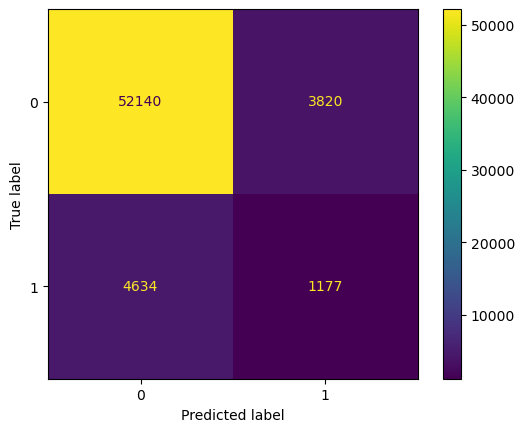

In [7]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=model.classes_)
disp.plot()
plt.show()

#### Podemos perceber que há um desequilíbrio no dataset: há muito mais pessoas que não possuem/ já possuíram doenças cardiovasculares do que pessoas que possuem/já possuíram. Comprovando o desequilíbrio:

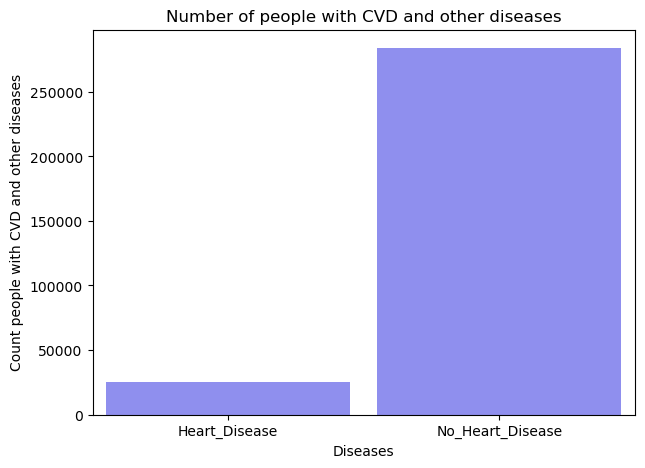

In [8]:
def graficoDiseaseCVD(tabela):
    '''Funcao que retorna um grafico de barras com a
    quantidade de pessoas em cada categoria de comorbidade a partir de uma tabela'''
    keys = ["Heart_Disease"]
    values = {}
    for key in keys:
        values[key] = len(tabela.query(f'{key} == "Yes"'))
        values['No_'+key] = len(tabela.query(f'{key} == "No"'))
    fig = plt.figure(figsize=(7,5))
    a,b = (zip(*values.items()))
    return list(a), list(b)

CVDDisease, countCVDDisease = graficoDiseaseCVD(df)
ax=sns.barplot(x=CVDDisease,y=countCVDDisease,color = 'blue', alpha = 0.5, width=0.9)
plt.title("Number of people with CVD and other diseases")
ax.set(xlabel="Diseases", ylabel="Count people with CVD and other diseases")

plt.show()

#### Vamos reselecionar os dados para treino:

In [9]:
rus = RandomUnderSampler(random_state=0)
underX, undery =rus.fit_resample(X_train, y_train)

In [10]:
# undersample = NearMiss(version=3, n_neighbors=3)
# underX, undery = undersample.fit_resample(X_train, y_train)

In [11]:
_model = DecisionTreeClassifier(random_state=42)
_model.fit(underX, undery) #treina o modelo

DecisionTreeClassifier(random_state=42)

In [12]:
predicted = _model.predict(X_test) #predicao (f(x))

accuracy = accuracy_score(predicted, y_test)
recall = recall_score(predicted, y_test) #muitos false negative
precision = precision_score(predicted, y_test) #muitos false positive
confusion = confusion_matrix(predicted, y_test)

print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"precision: {precision}")

accuracy: 0.6630457658124362
recall: 0.14594618793929354
precision: 0.6523914348609166


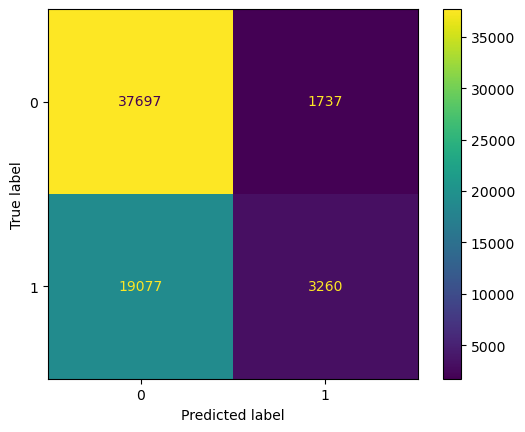

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=model.classes_)
disp.plot()
plt.show()

#### Podemos perceber que, mesmo com o dataset equilibrado, a árvore de decisão parece afetada de forma negativa. Portanto, não é o melhor modelo para a predição.